# Stock Portfolio Optimisation Tool Using Artificial Intelligence
## Thomas Lowe

In [1]:
%load_ext watermark
%load_ext tensorboard

In [2]:
#loads required packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import ipywidgets as w
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data as pdr
import warnings
import pyfolio as pf
import empyrical as ep
from yahoofinancials import YahooFinancials as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from math import sqrt
import csv

C:\Anaconda\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
C:\Anaconda\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [11]:
def display_widget():
    print ("\nPlease enter the dates you wish to retrieve stock data from")
    #Declare the widgets as global variables so they can be used in the next function
    global start_date_widget, end_date_widget
    start_date_widget = w.DatePicker(description='Start Date')
    end_date_widget = w.DatePicker(description='End Date')
    #Displays the widget datepicker that was just created
    display(start_date_widget, end_date_widget)

In [4]:
def date_from_widget():
    #converts the dates into strings
    start_date = str(start_date_widget.value)
    end_date = str(end_date_widget.value)
    return start_date, end_date

# Markowitz

In [5]:
#companylist.csv is made from a list of nasdaq listed companies as of 09/04/2020
#ftp://ftp.nasdaqtrader.com/symboldirectory
companylist = []
with open('companylist.csv', newline='') as inputfile:
    for row in csv.reader(inputfile):
        companylist.append(row[0])

In [ ]:
tickers = []
conditional = input("Would you like to use the placeholder tickers? Type 'n' to use your own.\n Any other entry will use placeholders.").lower()

if conditional == ("n"):
    counter = 0
    while counter != 1:
        firstTicker = input("\nPlease enter the first ticker here. I.e. AAPL.").upper()
        if firstTicker in companylist:
            tickers.append(firstTicker)
            counter = counter+1
        else:
            print (firstTicker+" is not a valid ticker. Please enter a valid ticker.")
    while counter != 2:
        secondTicker = input("Please enter the second ticker here. I.e. FB.").upper()
        if secondTicker in companylist:
            tickers.append(secondTicker)
            counter = counter+1
        else:
            print (secondTicker+" is not a valid ticker. Please enter a valid ticker.")
    while counter != 3:
        thirdTicker = input("Please enter the third ticker here. I.e. TSLA.").upper()
        if thirdTicker in companylist:
            tickers.append(thirdTicker)
            counter = counter+1
        else:
            print (thirdTicker+" is not a valid ticker. Please enter a valid ticker.")
    while counter != 4:
        fourthTicker = input("Please enter the fourth ticker here. I.e. MSFT.").upper()
        if fourthTicker in companylist:
            tickers.append(fourthTicker)
            counter = counter+1
        else:
            print (fourthTicker+" is not a valid ticker. Please enter a valid ticker.")
    print ("You have entered the following "+str(tickers))
else:
    #Declares the stock tickers that are to be used
    #Tickers are a stocks unique identifier
    tickers = ['FB','AAPL','TSLA','BP']
    
#Uses the tickers to get information from YahooFinancials package
yahoo_financials = yf(tickers)
display_widget()

In [54]:
date_from_widget()
#Pulls the start_date, end_date variables from the date_from_widget function
start_date,end_date = date_from_widget()
print(start_date,end_date)

1990-01-01 2020-01-01


In [55]:
data = yahoo_financials.get_historical_price_data(start_date,end_date,'daily')

prices_df = pd.DataFrame({
        asset: {x['formatted_date']: x['adjclose'] for x in data[asset]['prices']} for asset in tickers
})

prices_df.index.name="Formatted_Date"
prices_df.index = pd.to_datetime(prices_df.index)
prices_df.head()

,AAPL,FB,TSLA,MSFT
Formatted_Date,,,,
1990-01-02,1.078869,NaN,NaN,0.395434
1990-01-03,1.086111,NaN,NaN,0.397661
1990-01-04,1.089730,NaN,NaN,0.409357
1990-01-05,1.093350,NaN,NaN,0.399332
1990-01-08,1.100591,NaN,NaN,0.405459


Text(0.5, 0, 'Date')

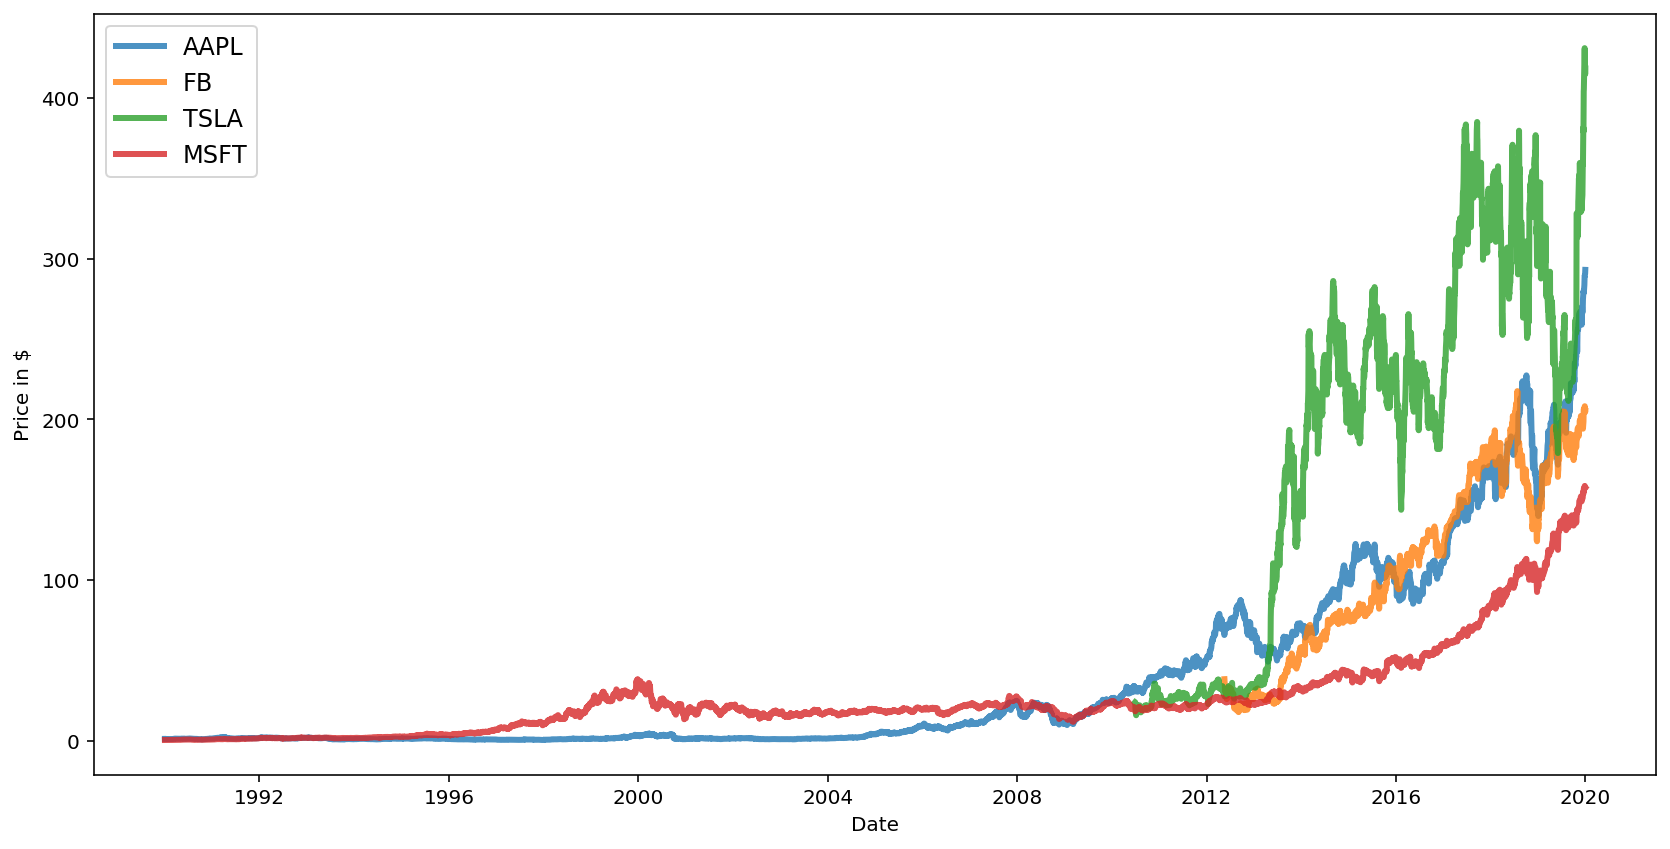

In [56]:
plt.figure(figsize=(14,7))
for c in prices_df.columns.values:
    plt.plot(prices_df.index,prices_df[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in $')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

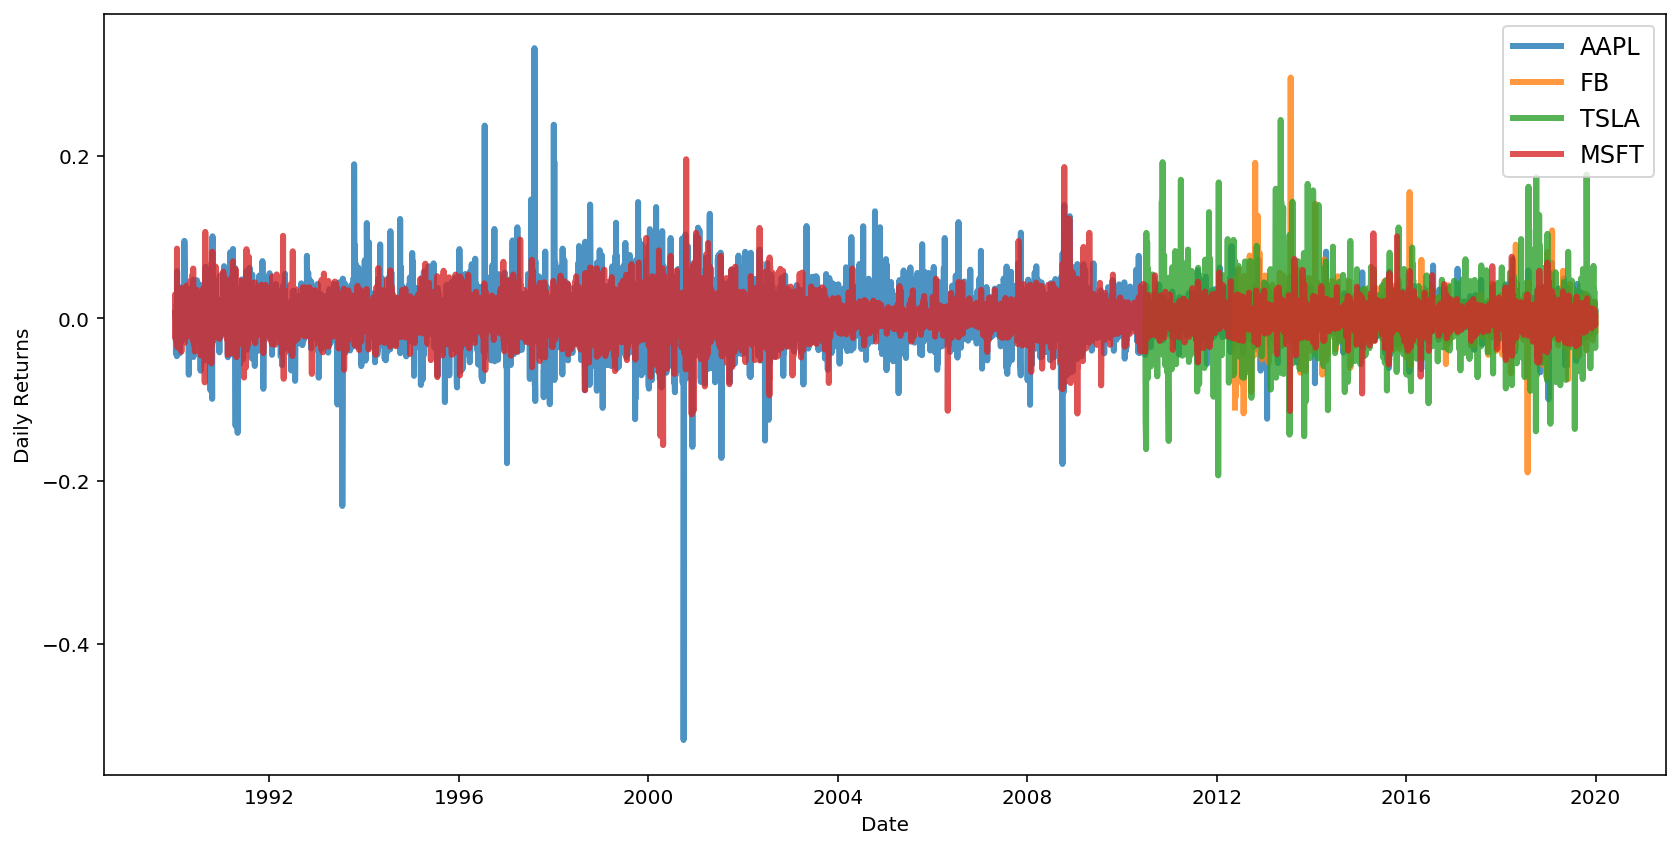

In [57]:
returns = prices_df.pct_change()

plt.figure(figsize=(14,7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8, label=c)
plt.legend(loc='upper right',fontsize=12)
plt.ylabel('Daily Returns')
plt.xlabel('Date')

In [58]:
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    #252 represents the number of trading days in a year
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [59]:
returns = prices_df.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [60]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=prices_df.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]

    max_sharpe_allocation.allocation
    max_sharpe_allocation = max_sharpe_allocation.T
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=prices_df.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print (prices_df)

    

    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.31
Annualised Volatility: 0.26


             AAPL     FB   TSLA  MSFT
allocation  15.56  29.47  26.46  28.5
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.29
Annualised Volatility: 0.25


             AAPL     FB   TSLA   MSFT
allocation  13.81  32.39  12.16  41.64
                      AAPL          FB        TSLA        MSFT
Formatted_Date                                                
1990-01-02        1.078869         NaN         NaN    0.395434
1990-01-03        1.086111         NaN         NaN    0.397661
1990-01-04        1.089730         NaN         NaN    0.409357
1990-01-05        1.093350         NaN         NaN    0.399332
1990-01-08        1.100591         NaN         NaN    0.405459
...                    ...         ...         ... 

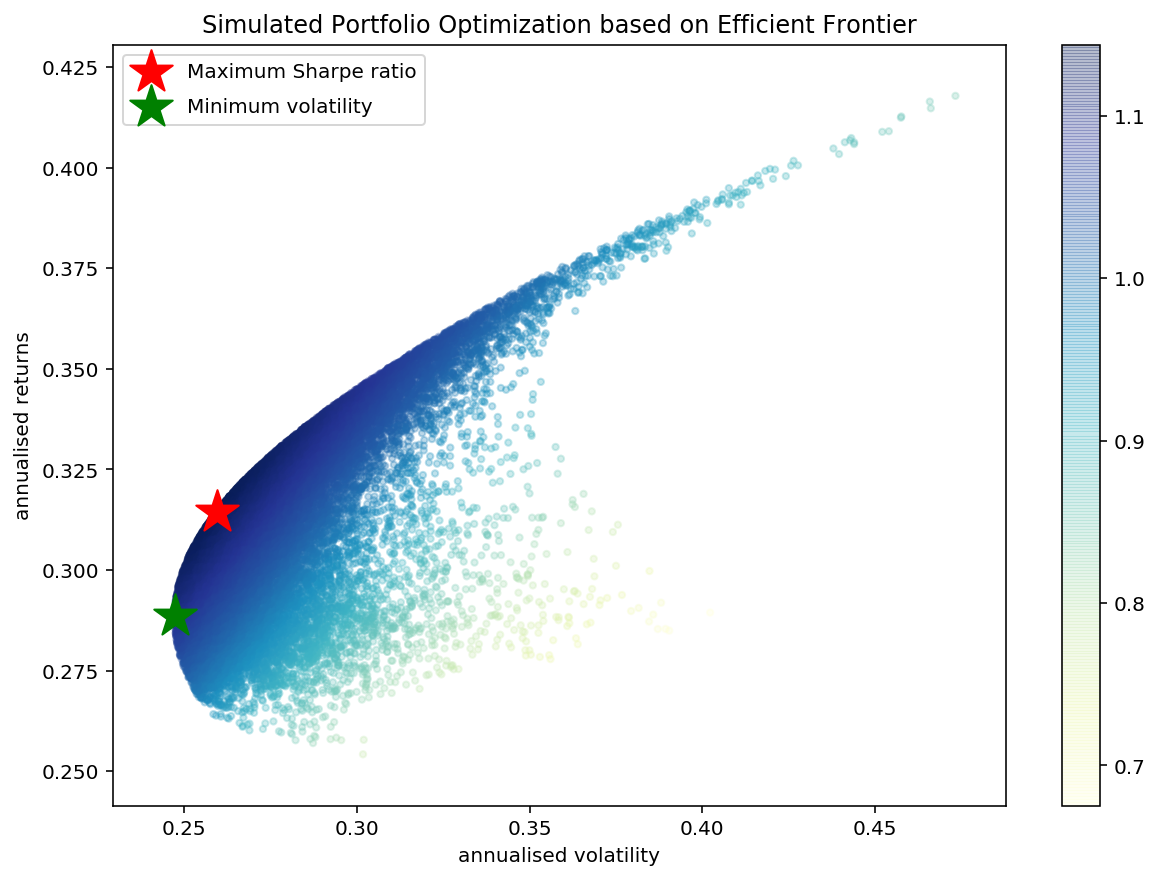

In [61]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Algorithm

In [42]:
display_widget()

Please enter the dates you wish to retrieve stock data from


DatePicker(value=None, description='Start Date')

DatePicker(value=None, description='End Date')

In [50]:
date_from_widget()
start_date,end_date = date_from_widget()
print(start_date,end_date)

2000-01-01 2020-01-01


In [37]:
ticker = input("Please enter a ticker here. I.e. BP.")
yahoo_finacials = yf(ticker)
data = yahoo_finacials.get_historical_price_data(start_date, end_date, "daily")

data

Please enter a ticker here. I.e. BP.BP


TypeError: int() argument must be a string, a bytes-like object or a number, not 'YahooFinancials'

In [52]:
userInput_df = pdr.get_data_yahoo(ticker,
                          start_date,
                          end_date
                          )
userInput_df.head()
userInput_df=userInput_df.Close
userInput_df.head()

Date
2000-01-03    58.28125
2000-01-04    56.31250
2000-01-05    56.90625
2000-01-06    55.00000
2000-01-07    55.71875
Name: Close, dtype: float64

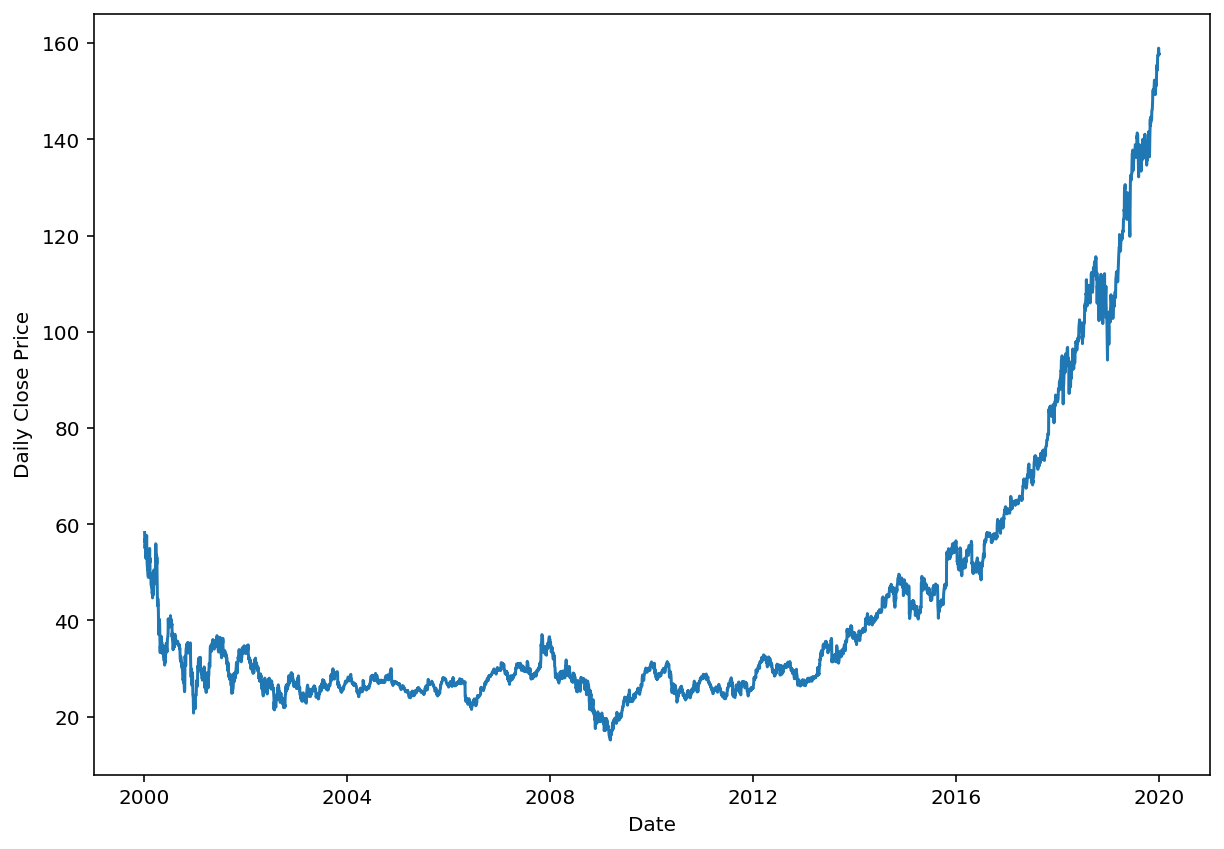

In [69]:
plt.figure(figsize=(10, 7))
plt.plot(userInput_df)
plt.ylabel('Daily Close Price')
plt.xlabel('Date')
plt.show()

In [54]:
X = userInput_df.values
train_size = int(len(X)*0.66)
train, test = X[1:train_size], X[train_size:]

RMSE: 1.081


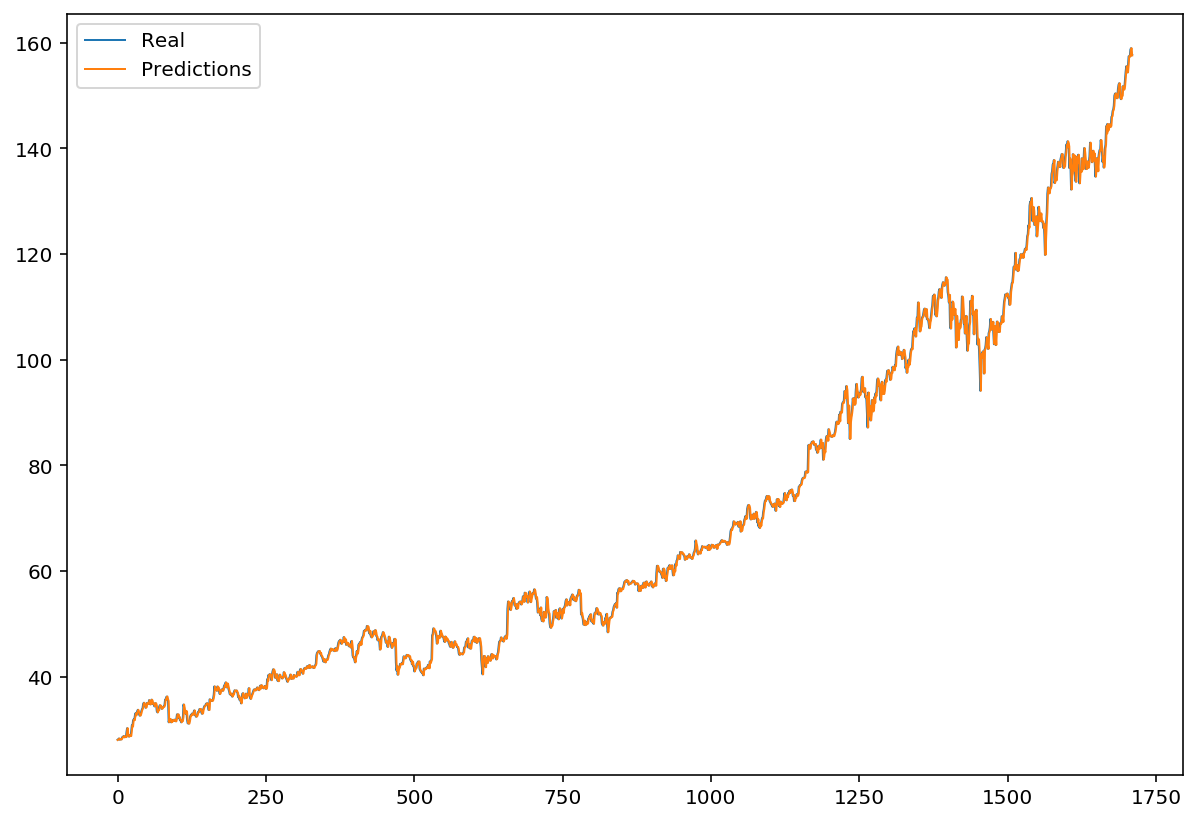

In [75]:
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    predictions.append(history[-1])
    history.append(test[i])
#This is the percentage that the predictions deviate from the actual values
#Close rmse is to 0, the more accurate the model is
rmse = sqrt(mean_squared_error(test,predictions))
print('RMSE: %.3f' % rmse)
plt.figure(figsize=(10, 7))
plt.plot(test, label='Real', linewidth=1)
plt.plot(predictions, label='Predictions', linewidth=1)
plt.legend(['Real','Predictions'])
plt.show()

# Prediction Method